In [320]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from sklearn.datasets import make_blobs

In [321]:
'''
    根据train_x和train_y画出二维散点图，并画出判别函数predict_discriminant
'''
def plt_show(train_x, train_y, predict_discriminant):
    plot = plt.scatter(train_x[:,0], train_x[:,1], c=train_y, s=30, marker='o', cmap=plt.cm.Spectral)
    if predict_discriminant:
        real_x = min(train_x[:,0]) + (max(train_x[:,0]) - min(train_x[:,0])) * np.random.random(50)
        real_y = predict_discriminant(real_x)
        plt.plot(real_x, real_y, 'r', label='predict discriminant')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc=1)
    plt.title('regression')
    plt.show()    

In [322]:
'''
    根据epoch_list和loss_list画出损失函数图像
'''
def plt_show_loss(epoch_list, loss_list):
    plt.plot(epoch_list, loss_list, 'r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [323]:
'''
    定义目标判别函数
'''
def aim_discriminant(x):
    return 3 * x + 2

In [324]:
'''
    在[0,1]上根据目标判别函数生成sample_N个二维数据点集，并添加一个N(0,1)的高斯噪声。
'''
def genData(sample_N, naive):
    n = np.ceil(sample_N / 2).astype(np.int32)
    lam = 0.2 # 随机变量方差
    cov_xy = 0.01 # 两个维度的协方差
    x_mean1 = [-0.6, -0.4] # 类别1的均值
    x_mean2 = [0.6, 0.4] # 类别2的均值
    train_x = np.zeros((sample_N, 2))
    train_y = np.zeros(sample_N)
    if naive: # 满足朴素贝叶斯假设
        train_x[:n,:] = np.random.multivariate_normal(x_mean1, [[lam, 0], [0, lam]], size=n)
        train_x[n:,:] = np.random.multivariate_normal(x_mean2, [[lam, 0], [0, lam]], size=sample_N-n)
        train_y[:n] = 0
        train_y[n:] = 1
    else: # 不满足朴素贝叶斯假设
        train_x[:n,:] = np.random.multivariate_normal(
            x_mean1, [[lam, cov_xy], [cov_xy, lam]], size=n)
        train_x[n:,:] = np.random.multivariate_normal(
            x_mean2, [[lam, cov_xy], [cov_xy, lam]], size=sample_N-n)
        train_y[:n] = 0
        train_y[n:] = 1
    return train_x, train_y

In [325]:
'''
    sigmoid函数
'''
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [326]:
'''
    极大条件似然
'''
def likelihood(train_x, train_y, weight):
    total = np.size(train_x, axis=0)
    predict = np.zeros((total, 1))
    for i in range(total):
        predict[i] = np.dot(weight, train_x[i].T)
    t = 0
    for i in range(total):
        t += np.log(1 + np.exp(predict[i]))
    return np.dot(train_y, predict) - t

In [327]:
'''
    根据train_x和train_y对参数w做梯度下降，并返回w
    训练最大轮数为epoch
    学习率eta
    迭代误差eps
    数据集样本维度dimension
    正则项超参数lam
'''
def descent_gradient(train_x, train_y, epoch, eta, eps, dimension, lam):
    total = np.size(train_x, axis=0)
    weight = np.ones((1, dimension + 1))
    epoch_list = np.zeros(epoch)
    loss_list = np.zeros(epoch)
    for i in range(epoch):
        old_loss = - 1 / total * likelihood(train_x, train_y, weight)
        t = np.zeros((total, 1))
        for j in range(total):
            t[j] = np.dot(weight, train_x[j].T)
        gradient = - 1 / total * np.dot(train_y - sigmoid(t.T), train_x)
        weight = weight - eta * lam * weight - eta * gradient # 梯度下降
        new_loss = - 1 / total * likelihood(train_x, train_y, weight)
        epoch_list[i] = i
        loss_list[i] = new_loss
        if i % 100 == 0:
            print(i, ', loss=', new_loss, ', weight=', weight, 'gradient=', gradient)            
        if abs(new_loss - old_loss) < eps:
            epoch_list = epoch_list[:i+1]
            loss_list = loss_list[:i+1]
            break
    return weight, epoch_list, loss_list

In [328]:
def custom_exp(sample_N, lam, naive):
    train_x, train_y = genData(sample_N, naive) # 生成数据
    # 构造X矩阵
    train_X = np.ones((sample_N, 3))
    train_X[:,1] = train_x[:,0]
    train_X[:,2] = train_x[:,1]
    # 规定梯度下降参数
    epoch = 1000000
    eta = 0.1
    eps = 1e-5
    # 执行训练
    weight, epoch_list, loss_list = descent_gradient(
        train_X, train_y, epoch, eta, eps, np.size(train_x, axis=1), lam)
    # 训练得到的weight是一个shape=(1, dimension=3)的矩阵
    # 需要先将weight改成行向量，对weight[dimension-1=2]做归一化，移项后得到判别函数解析式predict_discriminant
    weight = weight.reshape(3)
    coefficient = -(weight / weight[2])[0:2]
    predict_discriminant = np.poly1d(coefficient[::-1])
    print('The predict discriminant function: y = ', predict_discriminant)
    plt_show(train_x, train_y, predict_discriminant)
    plt_show_loss(epoch_list, loss_list)

0 , loss= [0.4304008] , weight= [[0.98125076 1.01630604 1.00874562]] gradient= [[ 0.18749236 -0.16306042 -0.08745617]]
100 , loss= [0.21579879] , weight= [[0.15375089 1.98183728 1.5434698 ]] gradient= [[ 0.03386898 -0.06460842 -0.03764196]]
200 , loss= [0.17392498] , weight= [[-0.04790915  2.50283457  1.8585775 ]] gradient= [[ 0.01208833 -0.04299544 -0.02701478]]
300 , loss= [0.1533995] , weight= [[-0.13546027  2.87486861  2.09959679]] gradient= [[ 0.00652745 -0.03251322 -0.02172079]]
400 , loss= [0.14064186] , weight= [[-0.18926273  3.16569717  2.29904319]] gradient= [[ 0.00454145 -0.02617619 -0.01842447]]
500 , loss= [0.13179526] , weight= [[-0.22956812  3.40466265  2.47111642]] gradient= [[ 0.00362854 -0.02191251 -0.01613682]]
600 , loss= [0.12523932] , weight= [[-0.26305068  3.60752344  2.62351939]] gradient= [[ 0.00311444 -0.0188446  -0.01443713]]
700 , loss= [0.12015493] , weight= [[-0.29238875  3.78377948  2.7609498 ]] gradient= [[ 0.00277655 -0.01653082 -0.01311289]]
800 , loss

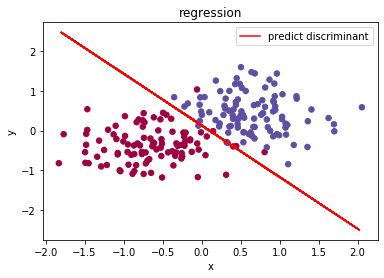

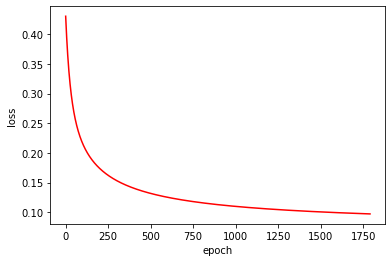

In [329]:
naive = True
custom_exp(200, 0, naive)

0 , loss= [0.44767362] , weight= [[0.98134961 1.0149551  1.00886388]] gradient= [[ 0.18650389 -0.14955098 -0.08863884]]
100 , loss= [0.25277418] , weight= [[0.17099959 1.9038858  1.5197312 ]] gradient= [[ 0.03175935 -0.05918811 -0.03336301]]
200 , loss= [0.21918262] , weight= [[-0.01093261  2.37830773  1.78552781]] gradient= [[ 0.01031235 -0.03888295 -0.02166304]]
300 , loss= [0.20394597] , weight= [[-0.08281144  2.71256561  1.97111081]] gradient= [[ 0.00514625 -0.02900305 -0.01605328]]
400 , loss= [0.19507939] , weight= [[-0.1242652   2.97020796  2.11345237]] gradient= [[ 0.00343011 -0.02301869 -0.01269782]]
500 , loss= [0.18930075] , weight= [[-0.15437796  3.17884807  2.22845179]] gradient= [[ 0.00268614 -0.01898826 -0.01045999]]
600 , loss= [0.18526553] , weight= [[-0.1790047   3.35334666  2.32456196]] gradient= [[ 0.00227633 -0.01608608 -0.00885982]]
700 , loss= [0.18231064] , weight= [[-0.20031526  3.50266831  2.40682382]] gradient= [[ 0.00200353 -0.01389552 -0.00765763]]
800 , lo

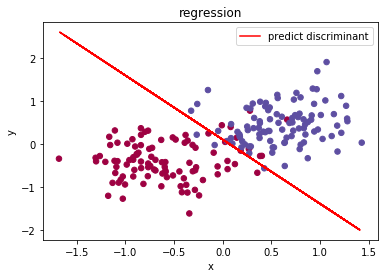

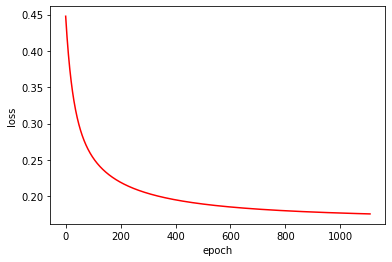

In [330]:
custom_exp(200, 0, not naive)

0 , loss= [0.41819725] , weight= [[0.98325281 1.01554138 1.01049656]] gradient= [[ 0.16647192 -0.15641375 -0.10596565]]
100 , loss= [0.22993378] , weight= [[0.32668909 1.91238265 1.63804164]] gradient= [[ 0.02000762 -0.05999575 -0.04434853]]
200 , loss= [0.19363574] , weight= [[0.23719617 2.37096016 1.98763447]] gradient= [[ 0.0023992  -0.03941058 -0.03131872]]
300 , loss= [0.17561461] , weight= [[0.23257258 2.68628258 2.24520772]] gradient= [[-0.0010566  -0.02978066 -0.02509444]]
400 , loss= [0.16441877] , weight= [[0.24538918 2.92510422 2.45221576]] gradient= [[-0.00178089 -0.0240893  -0.02131405]]
500 , loss= [0.15670602] , weight= [[0.26125366 3.11556363 2.62617054]] gradient= [[-0.00184802 -0.0203175  -0.01872883]]
600 , loss= [0.15104385] , weight= [[0.27660927 3.27254182 2.77639282]] gradient= [[-0.00175049 -0.01763607 -0.01682726]]
700 , loss= [0.14670015] , weight= [[0.29062957 3.40494946 2.90852163]] gradient= [[-0.00162142 -0.01563619 -0.01535753]]
800 , loss= [0.14325831] ,

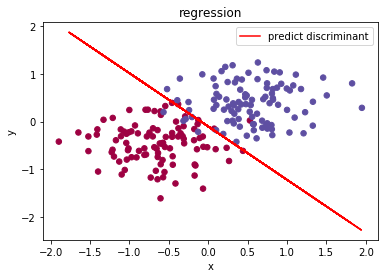

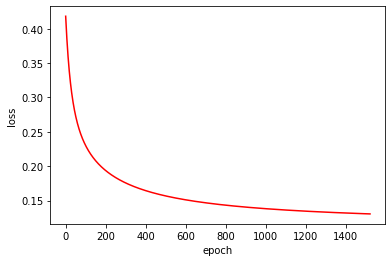

In [331]:
custom_exp(200, 0.001, naive)

0 , loss= [0.44684712] , weight= [[0.98151464 1.01674229 1.00736259]] gradient= [[ 0.18385361 -0.16842293 -0.07462593]]
100 , loss= [0.2441195] , weight= [[0.19927722 2.00899531 1.40994104]] gradient= [[ 0.02885945 -0.06742307 -0.02635343]]
200 , loss= [0.20875728] , weight= [[0.04125889 2.52724515 1.60478908]] gradient= [[ 0.008093   -0.04444549 -0.0172276 ]]
300 , loss= [0.19272943] , weight= [[-0.01000715  2.88367967  1.73745912]] gradient= [[ 0.003186   -0.03345141 -0.01311828]]
400 , loss= [0.18342459] , weight= [[-0.03249225  3.15244185  1.83772451]] gradient= [[ 0.00163373 -0.02690105 -0.01072087]]
500 , loss= [0.177371] , weight= [[-0.04498316  3.36550819  1.91766404]] gradient= [[ 0.00103331 -0.02254515 -0.00913766]]
600 , loss= [0.17314957] , weight= [[-0.05327488  3.53993549  1.98354454]] gradient= [[ 0.00075801 -0.01944124 -0.00801041]]
700 , loss= [0.17006162] , weight= [[-0.05947835  3.6859632   2.0390772 ]] gradient= [[ 0.00061048 -0.01712068 -0.00716576]]
800 , loss= [0

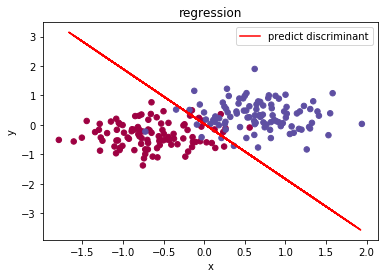

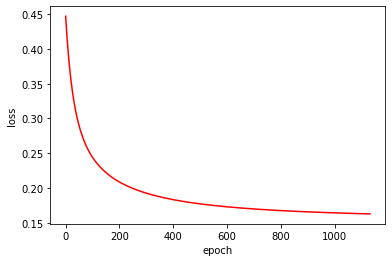

In [332]:
custom_exp(200, 0.001, not naive)

In [333]:
'''
    生成skin数据集数据
'''
def skin_gen_data():
    load_data = np.loadtxt('./Skin_NonSkin.txt', dtype=np.int32)
    np.random.shuffle(load_data) # 打乱原数据，以便分成训练集和测试集
    test_data_rate = 0.2 # 测试集比例
    load_data_size = np.size(load_data, axis=0)
    train_data = load_data[:int(test_data_rate * load_data_size), :] # 训练集数据
    test_data = load_data[int(test_data_rate * load_data_size):, :] # 测试集数据
    dim = np.size(load_data, axis=1) - 1 # 训练集样本维度
    
    step = 50 # 本数据集太大，采用步长为50的方式，选取打乱的数据
    train_x = train_data[:,0:dim]
    train_x = train_x[::step]
    train_x = train_x - 100 # 对样本点进行坐标平移
    train_y = train_data[:,dim:dim + 1] - 1
    train_y = train_y[::step]
    train_size = np.size(train_x, axis=0)
    train_y = train_y.reshape(train_size) # 矩阵转化为行向量 

    test_x = test_data[:,0:dim]
    test_x = test_x[::step] - 100  # 对样本点进行坐标平移
    test_y = test_data[:,dim:dim + 1] - 1
    test_y = test_y[::step]
    test_size = np.size(test_x, axis=0)
    test_y = test_y.reshape(test_size) # 矩阵转化为行向量
    return train_x, train_y, test_x, test_y

In [334]:
'''
    由于skin数据集是三维的，可以画出三维立体图像
'''
from mpl_toolkits.mplot3d import Axes3D
def skin_show_3D(train_x, train_y, coefficient):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(train_x[:,0], train_x[:,1], train_x[:,2], c=train_y, cmap=plt.cm.Spectral)
    real_x = np.arange(np.min(train_x[:,0]), np.max(train_x[:,0]), 1)
    real_y = np.arange(np.min(train_x[:,1]), np.max(train_x[:,1]), 1)
    real_X, real_Y = np.meshgrid(real_x, real_y)
    real_z = coefficient[0] + coefficient[1] * real_X + coefficient[2] * real_Y
    ax.plot_surface(real_x, real_y, real_z, rstride=1, cstride=1)
    ax.set_zlim(np.min(real_z) - 10, np.max(real_z) + 10)
    ax.legend(loc='best')
    plt.show()

In [335]:
'''
    用uci上Skin_NonSkin.txt数据集实验
'''
def skin_exp(lam):
    train_x, train_y, test_x, test_y = skin_gen_data()
    train_size = np.size(train_x, axis=0) # 训练样本数量
    test_size = np.size(test_x, axis=0) # 测试样本数量
    dim = np.size(train_x, axis=1) # 样本维度
    
    # 构造训练集矩阵
    train_X = np.ones((train_size, dim + 1)) 
    train_X[:,1] = train_x[:,0]
    train_X[:,2] = train_x[:,1]
    train_X[:,3] = train_x[:,2]
    # 设置参数，开始训练
    epoch = 1000000
    eta = 0.001
    eps = 1e-5
    weight, epoch_list, loss_list = descent_gradient(train_X, train_y, epoch, eta, eps, dim, lam)
    weight = weight.reshape(dim + 1) # 训练结果参数重塑
    coefficient = - (weight / weight[dim])[0:dim] # 得到决策面方程系数
    # 画图
    plt_show_loss(epoch_list, loss_list)
    skin_show_3D(train_x, train_y, coefficient)
    # 计算测试集的准确率
    label = np.ones(test_size)
    correct_count = 0
    test_X = np.ones((test_size, dim + 1))
    test_X[:,1] = test_x[:,0]
    test_X[:,2] = test_x[:,1]
    test_X[:,3] = test_x[:,2]
    for i in range(test_size):
        if np.dot(weight, test_X[i].T) >= 0:
            label[i] = 1
        else:
            label[i] = 0
        if label[i] == test_y[i]:
            correct_count += 1
    correct_rate = correct_count / test_size
    print(correct_rate)

0 , loss= [78.0732635] , weight= [[1.00006045 0.98252067 0.97690828 0.96000533]] gradient= [[-0.06045196 17.47932615 23.09172081 39.99466543]]
100 , loss= [0.80464362] , weight= [[ 1.00863631  0.09626433  0.08062129 -0.16601919]] gradient= [[-0.07696413  2.61200237  0.66825174 -3.13056851]]
200 , loss= [0.25784807] , weight= [[ 1.01549561  0.00858208  0.0303685  -0.04090911]] gradient= [[-0.06732764 -0.07439327  0.11880689 -0.04801726]]


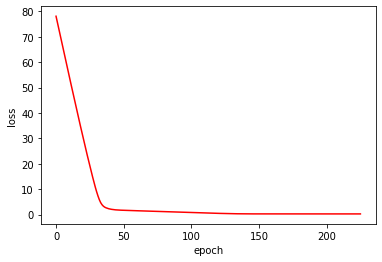

No handles with labels found to put in legend.


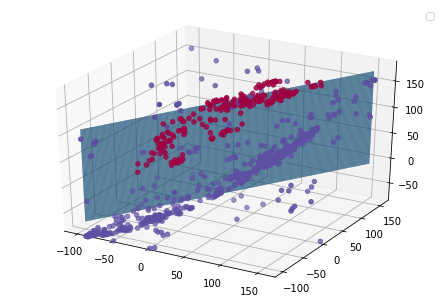

0.9466972711043101


In [336]:
skin_exp(0)

0 , loss= [77.38886887] , weight= [[1.00004208 0.98305931 0.97690587 0.96016225]] gradient= [[-0.05208352 16.93068734 23.08412807 39.82774965]]
100 , loss= [0.34776756] , weight= [[ 1.00989463  0.03055627 -0.01119228 -0.02029575]] gradient= [[-0.11392781  0.81555458 -0.46662685 -0.24005138]]


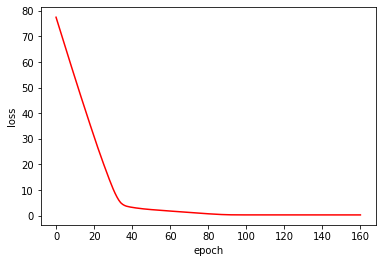

No handles with labels found to put in legend.


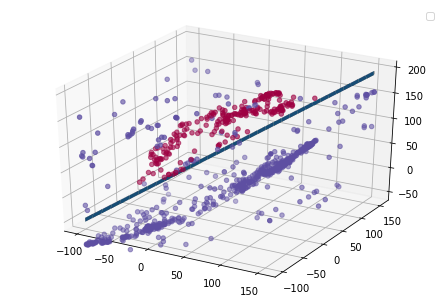

0.9380260137719969


In [337]:
skin_exp(0.01)

In [338]:
'''
    生成banknote数据集数据
'''
def banknote_gen_data():
    load_data = np.loadtxt('./data_banknote_authentication.txt', dtype=np.float32)
    np.random.shuffle(load_data) # 打乱原数据，以便分成训练集和测试集
    test_data_rate = 0.2 # 测试集比例
    load_data_size = np.size(load_data, axis=0) # 数据数量
    train_data = load_data[:int(test_data_rate * load_data_size), :] # 训练集数据
    test_data = load_data[int(test_data_rate * load_data_size):, :] # 测试集数据
    dim = np.size(load_data, axis=1) - 1 # 训练集样本维度
    
    train_x = train_data[:,0:dim]
    train_y = train_data[:,dim:dim + 1] - 1
    train_size = np.size(train_x, axis=0)
    train_y = train_y.reshape(train_size) # 矩阵转化为行向量 

    test_x = test_data[:,0:dim]
    test_y = test_data[:,dim:dim + 1] - 1
    test_size = np.size(test_x, axis=0)
    test_y = test_y.reshape(test_size) # 矩阵转化为行向量
    return train_x, train_y, test_x, test_y

In [339]:
'''
    根据banknote数据集实验
'''
def banknote_exp(lam):
    train_x, train_y, test_x, test_y = uci_gen_data()
    train_size = np.size(train_x, axis=0) # 训练集大小
    test_size = np.size(test_x, axis=0) # 测试集大小
    dim = np.size(train_x, axis=1) # 训练集样本维度
    # 构造训练集样本矩阵
    train_X = np.ones((train_size, dim + 1))
    for i in range(dim):
        train_X[:,i + 1] = train_x[:, i]
    # 设置参数，开始训练
    epoch = 1000000
    eta = 0.001
    eps = 1e-5
    weight, epoch_list, loss_list = descent_gradient(train_X, train_y, epoch, eta, eps, dim, lam)
    weight = weight.reshape(dim + 1)
    coefficient = - (weight / weight[dim])[0:dim] # 得到决策面方程系数
    # 画损失函数图像
    plt_show_loss(epoch_list, loss_list)    
    # 计算测试集准确率
    label = np.ones(test_size)
    correct_count = 0
    test_X = np.ones((test_size, dim + 1))
    for i in range(dim):
        test_X[:,i + 1] = test_x[:,i]
    for i in range(test_size):
        if np.dot(weight, test_X[i].T) >= 0:
            label[i] = 1
        else:
            label[i] = 0
        if label[i] == test_y[i]:
            correct_count += 1
    correct_rate = correct_count / test_size
    print(correct_rate)

0 , loss= [77.13798766] , weight= [[1.0001202  0.98208272 0.97701579 0.96130074]] gradient= [[-0.12020095 17.91728485 22.98421046 38.69926347]]
100 , loss= [0.32413507] , weight= [[ 1.0121294   0.02252103  0.00370694 -0.02808576]] gradient= [[-0.11001286  1.11397612  0.40950939 -1.34369195]]
200 , loss= [0.31811913] , weight= [[ 1.02302295  0.0173383   0.00385723 -0.02385568]] gradient= [[-1.08002147e-01 -1.87628320e-05  4.89474639e-04  1.51656178e-04]]
300 , loss= [0.31696465] , weight= [[ 1.03376676  0.01740681  0.00372502 -0.02384976]] gradient= [[-0.10690092 -0.00085615  0.00153195 -0.0001108 ]]
400 , loss= [0.31583308] , weight= [[ 1.04440306  0.01749284  0.00357182 -0.02383889]] gradient= [[-1.05838525e-01 -8.58820787e-04  1.52524905e-03 -1.04923621e-04]]
500 , loss= [0.31472382] , weight= [[ 1.05493396  0.01757838  0.00342022 -0.02382884]] gradient= [[-1.04792670e-01 -8.52051066e-04  1.50698368e-03 -9.62876568e-05]]
600 , loss= [0.31363632] , weight= [[ 1.06536109  0.01766324  0

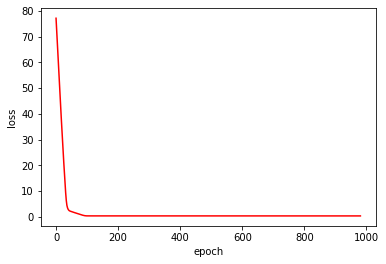

0.9382810507523591


In [340]:
banknote_exp(0)

0 , loss= [76.83953028] , weight= [[1.00004489 0.9832704  0.97733132 0.9600917 ]] gradient= [[-0.05488676 16.71959601 22.65868104 39.89830429]]
100 , loss= [0.89789853] , weight= [[ 1.00753468  0.13236574  0.04148546 -0.15919396]] gradient= [[-0.07937962  2.44036901  1.22793437 -3.45650807]]


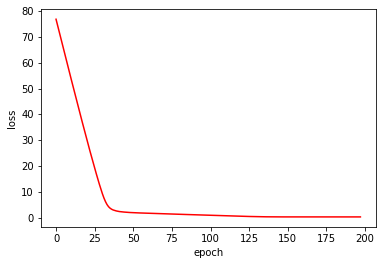

0.9410864575363428


In [341]:
banknote_exp(0.01)